In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *

In [2]:
DATA_FOLDER='./data/'
PATHS_AND_GRAPH = DATA_FOLDER + 'wikispeedia_paths-and-graph/'
PATHS_FINISHED = PATHS_AND_GRAPH + 'paths_finished.tsv'
PATHS_UNFINISHED = PATHS_AND_GRAPH + 'paths_unfinished.tsv'

In [3]:
#data exploration
paths_finished = pd.read_csv(PATHS_FINISHED, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'], encoding='utf-8', skiprows=16).copy(deep=True)
paths_finished["timestamp"] = pd.to_datetime(paths_finished["timestamp"], unit='s')
paths_finished.head()


,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,2011-02-15 03:26:49,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,2012-08-12 06:36:52,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,2012-10-03 21:10:40,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,2013-04-23 15:27:08,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


In [4]:
paths_unfinished= pd.read_csv(PATHS_UNFINISHED, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'], encoding='utf-8', skiprows=17).copy(deep=True)
paths_unfinished["timestamp"] = pd.to_datetime(paths_unfinished["timestamp"], unit='s')
paths_unfinished.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,2011-02-07 05:02:15,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,2011-02-07 05:14:11,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,2011-02-07 15:00:19,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,2011-02-07 16:06:01,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,2011-02-07 17:18:25,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


c:\Users\Cyril\anaconda3\envs\ada\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


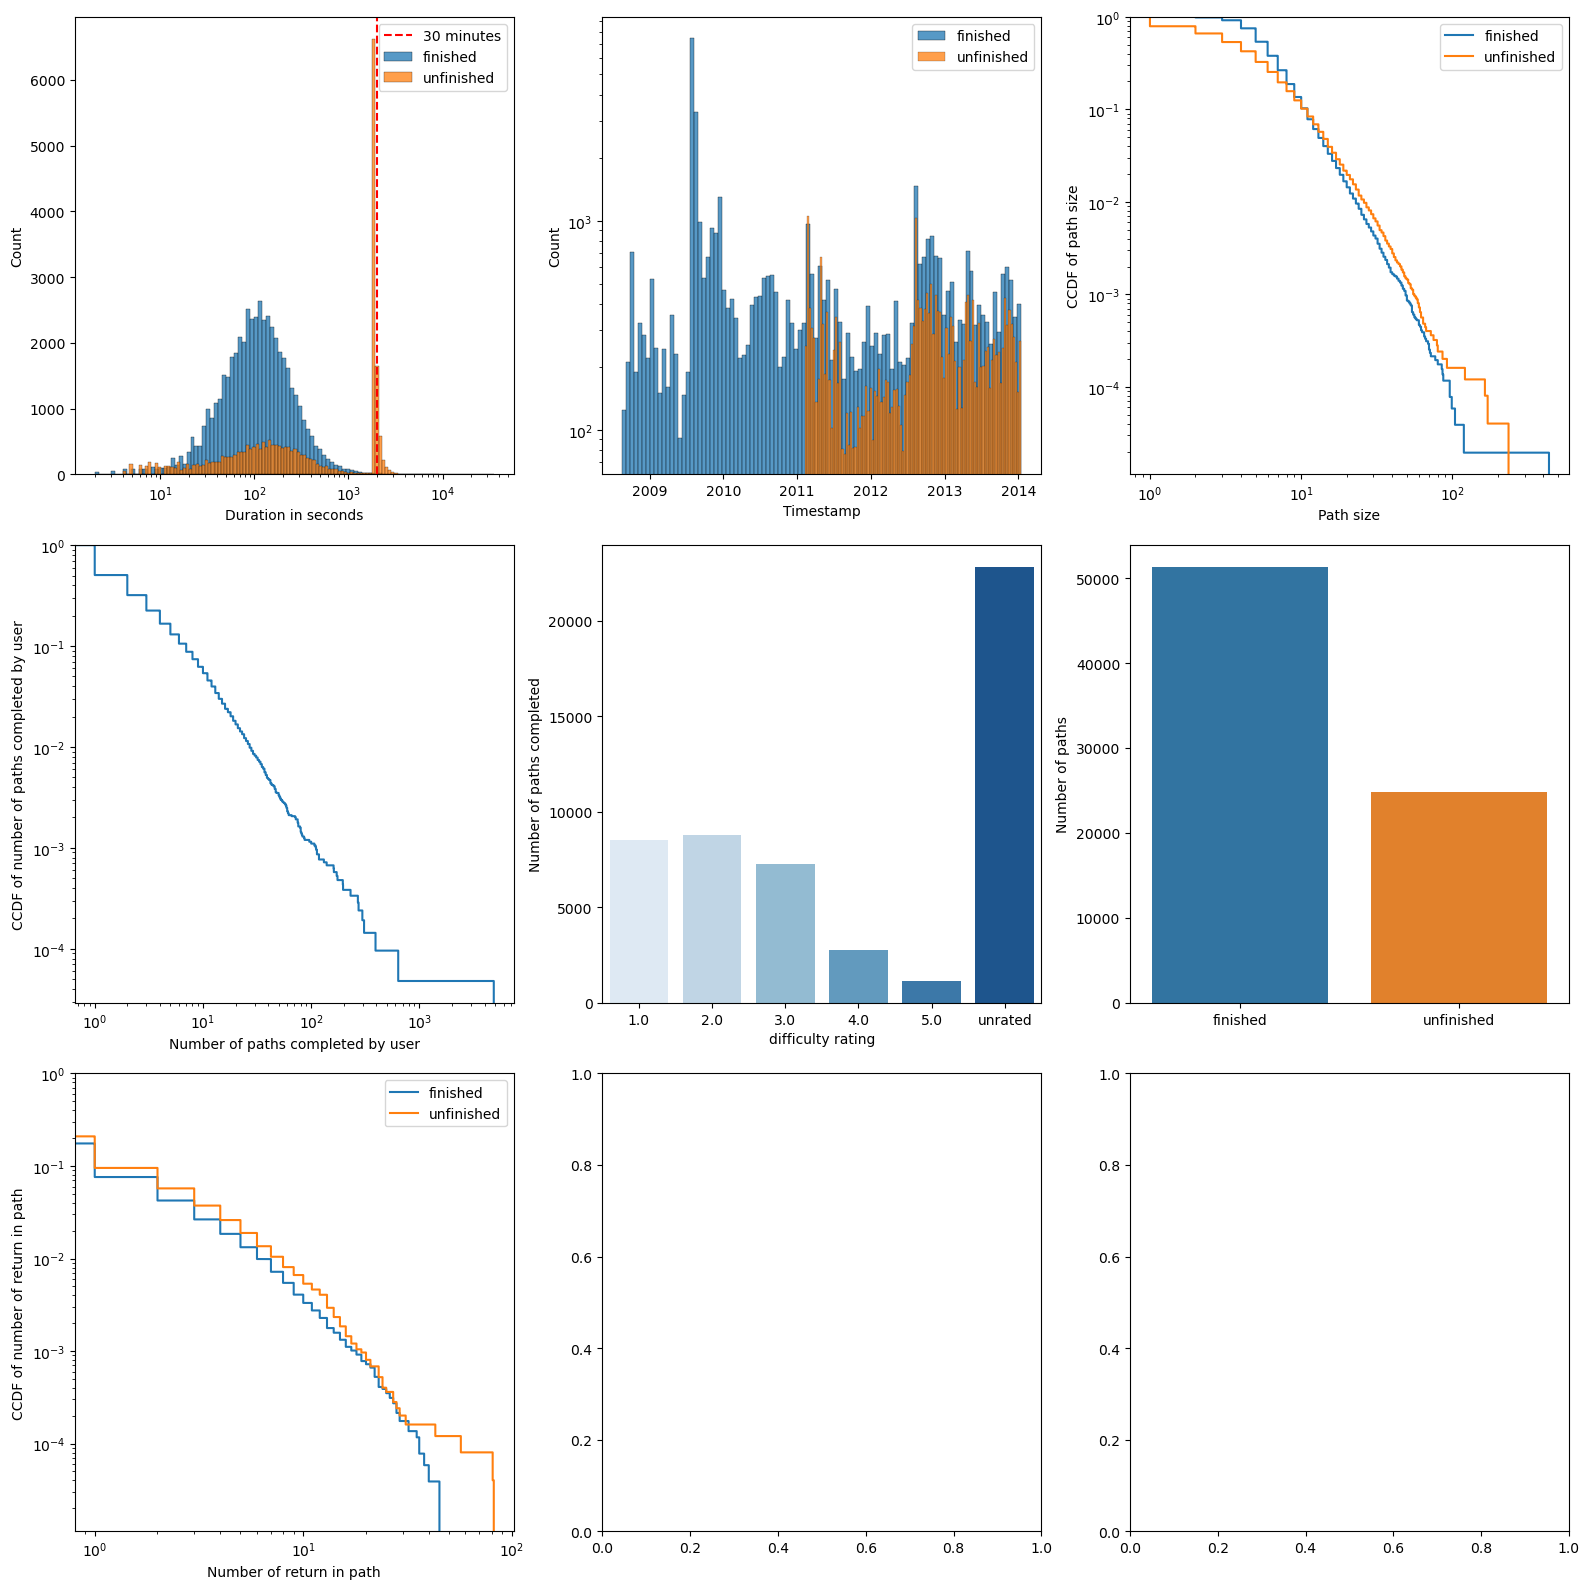

In [5]:
#visualize the finished and unfinished paths dataset in 3*3 subplots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(16, 16))
#duration over 1 second (for log scale)
sns.histplot(paths_finished['durationInSec'].loc[paths_finished['durationInSec'] > 1], bins=100, log_scale=True, label='finished', ax=axs[0,0])
sns.histplot(paths_unfinished['durationInSec'].loc[paths_unfinished['durationInSec'] > 1], bins=100, log_scale=True, label='unfinished', ax=axs[0,0])
axs[0,0].set_xlabel('Duration in seconds')
#add a bar at 30 minutes
axs[0,0].axvline(30*60+200, color='red', linestyle='--', label='30 minutes')
axs[0,0].legend()

#timestamp
sns.histplot(paths_finished['timestamp'], bins=100, label='finished', ax=axs[0,1])
sns.histplot(paths_unfinished['timestamp'], bins=100, label='unfinished', ax=axs[0,1])
axs[0,1].set_yscale('log')
axs[0,1].set_xlabel('Timestamp')
axs[0,1].legend()

#size of the path in log scale
sns.ecdfplot(paths_finished['path'].str.split(';').str.len(), label='finished', ax=axs[0,2], complementary=True).set(xscale='log',yscale='log', ylabel='CCDF of path size', xlabel='Path size')
sns.ecdfplot(paths_unfinished['path'].str.split(';').str.len(), label='unfinished', ax=axs[0,2], complementary=True).set(xscale='log',yscale='log', ylabel='CCDF of path size', xlabel='Path size')
axs[0,2].legend()

#number of paths completed by user with in x the number of paths and in y the number of users using the ccdf
combined_users = pd.concat([paths_finished['hashedIpAddress'], paths_unfinished['hashedIpAddress']])
sns.ecdfplot(combined_users.value_counts(), ax=axs[1,0], complementary=True).set(xscale='log',yscale='log', ylabel='CCDF of number of paths completed by user', xlabel='Number of paths completed by user')

#rating distribution
n_unrated = paths_finished['rating'].isna().sum()
x = paths_finished['rating'].value_counts().index.values
#sort the values since 2 is before 1
y = paths_finished['rating'].value_counts().values[x.argsort()]
x.sort()
#add the number of unrated paths
x = np.append(x, 'unrated')
y = np.append(y, n_unrated)
sns.barplot(x=x, y=y, palette="Blues",ax=axs[1,1]).set(ylabel='Number of paths completed', xlabel='difficulty rating')

#number of unfinished paths and finished paths
sns.barplot(x=['finished', 'unfinished'], y=[len(paths_finished), len(paths_unfinished)], ax=axs[1,2]).set(ylabel='Number of paths', xlabel='')

#number of return in the path ("<")
sns.ecdfplot(paths_finished['path'].str.count('<'), label='finished', ax=axs[2,0], complementary=True).set(xscale='log',yscale='log', ylabel='CCDF of number of return in path', xlabel='Number of return in path')
sns.ecdfplot(paths_unfinished['path'].str.count('<'), label='unfinished', ax=axs[2,0], complementary=True).set(xscale='log',yscale='log', ylabel='CCDF of number of return in path', xlabel='Number of return in path')
axs[2,0].legend()
plt.tight_layout()

### Longer paths more challenging -> lead to giving up?

54 paths given up on in common with finished


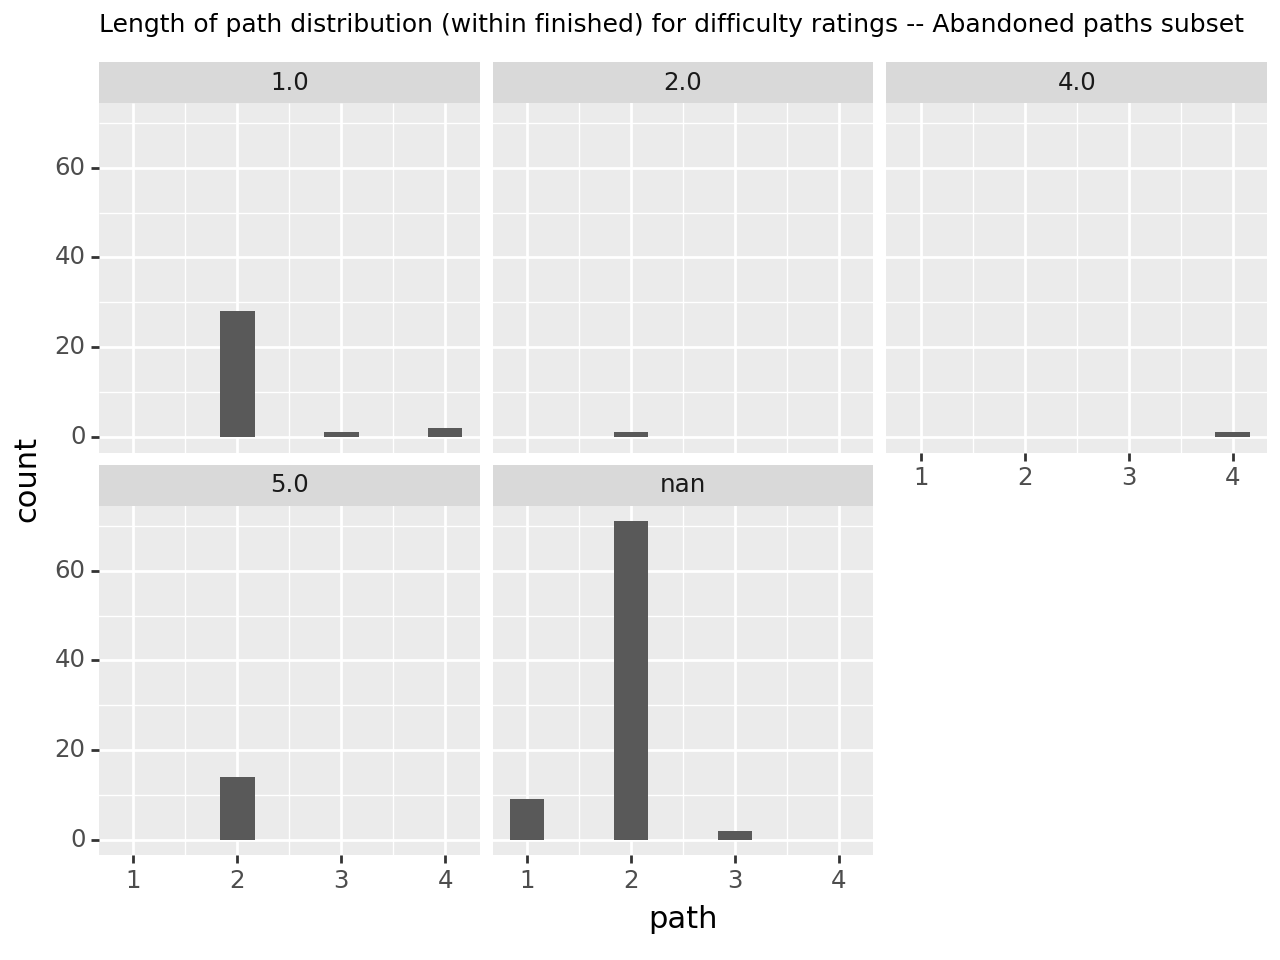

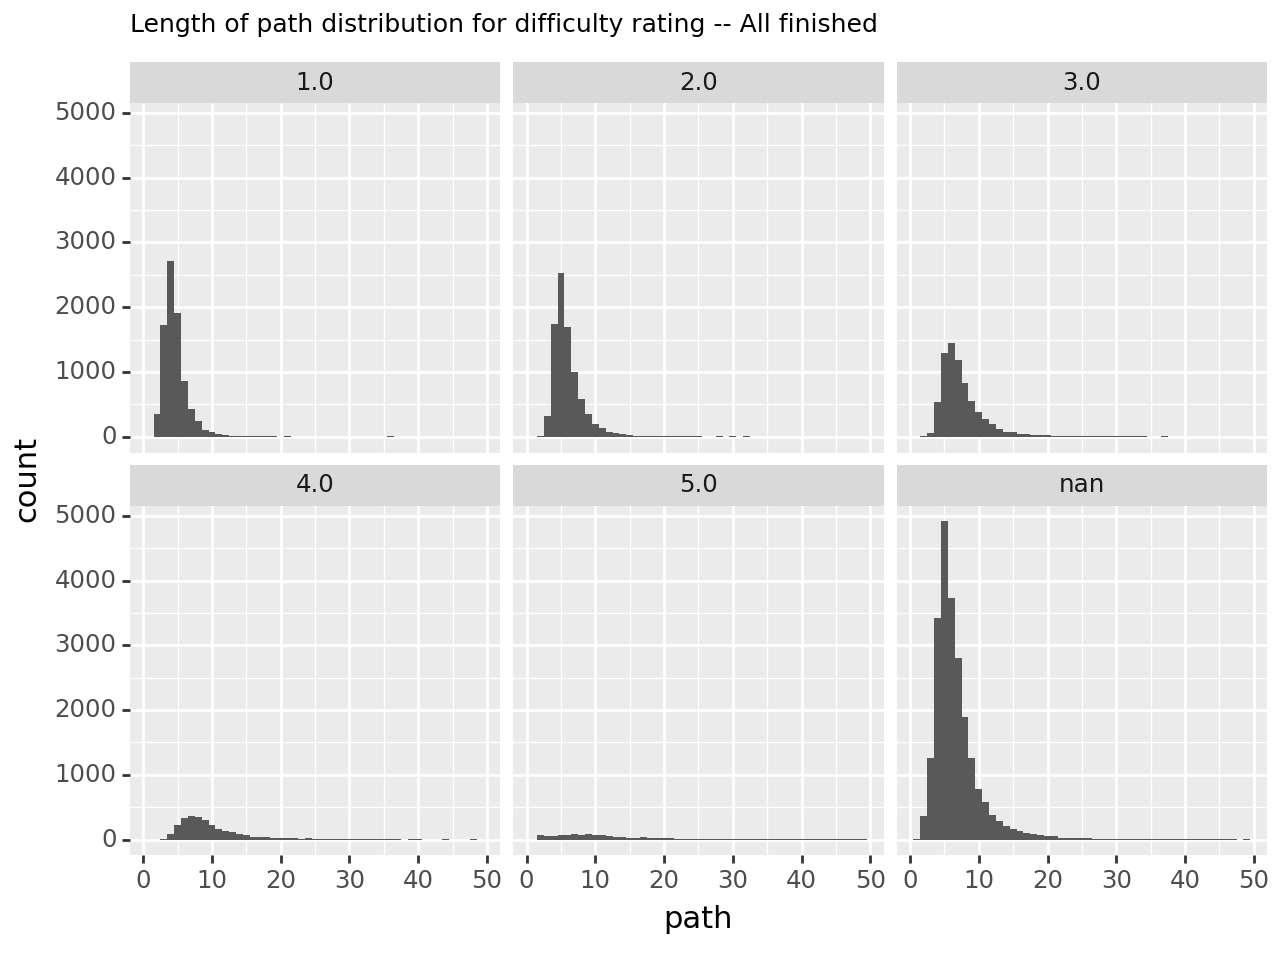

In [6]:
paths_finished_set = set(paths_finished['path']) # Get finished paths
given_up_paths = set(paths_unfinished['path']) # Get unfinished paths

# These are both sets of strings

common_paths = paths_finished_set.intersection(given_up_paths)
print(len(common_paths), 'paths given up on in common with finished')

common_path_idx = np.concatenate([np.where(paths_finished['path'] == x)[0] for x in common_paths])



paths_and_len_common = paths_finished.iloc[common_path_idx][['path', 'rating']].copy()
paths_and_len_common['path'] = paths_and_len_common['path'].apply(lambda x: len(x.split(';')))


p1 = ggplot(paths_and_len_common) \
	+ geom_histogram(aes(x='path'), bins=10) \
	+ facet_wrap('~ rating') \
	+ labs(title='Length of path distribution (within finished) for difficulty ratings -- Abandoned paths subset') \
	+ theme(plot_title = element_text(size=9))

print(p1)

paths_and_len_all = paths_finished[['path', 'rating']].copy()
paths_and_len_all['path'] = paths_and_len_all['path'].apply(lambda x: len(x.split(';')))

paths_and_len_all = paths_and_len_all.sort_values(by='path')
paths_and_len_all = paths_and_len_all[:-50]

p2 = ggplot(paths_and_len_all) \
	+ geom_histogram(aes(x = 'path'), binwidth=1) \
	+ facet_wrap('~ rating') \
	+ labs(title='Length of path distribution for difficulty rating -- All finished') \
	+ theme(plot_title=element_text(size=9))

print(p2)

Conclusion (for now): not enough data to determine whether or not certain characteristics are going to make people give up:
* only 54 points
* within the given up subset that has ratings, there's no obervable immediate difference between 1.0 and 5.0 difficulty score, which is a problem. The difference is a lot more observable between all finished paths. (see 1 vs 4 for ex.)

### Time per edge

In [7]:
from collections import defaultdict

,durationInSec,path,path_length
0,166,14th_century;15th_century;16th_century;Pacific...,9
1,88,14th_century;Europe;Africa;Atlantic_slave_trad...,5
2,138,14th_century;Niger;Nigeria;British_Empire;Slav...,8
3,37,14th_century;Renaissance;Ancient_Greece;Greece,4
4,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,7
...,...,...,...
51313,66,Yagan;Ancient_Egypt;Civilization,3
51314,165,Yagan;Folklore;Brothers_Grimm;<;19th_century;C...,9
51315,228,Yagan;Australia;England;France;United_States;T...,7
51316,56,Yarralumla%2C_Australian_Capital_Territory;Aus...,4


c:\Users\Cyril\anaconda3\envs\ada\lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 333'. Pick better value with 'binwidth'.


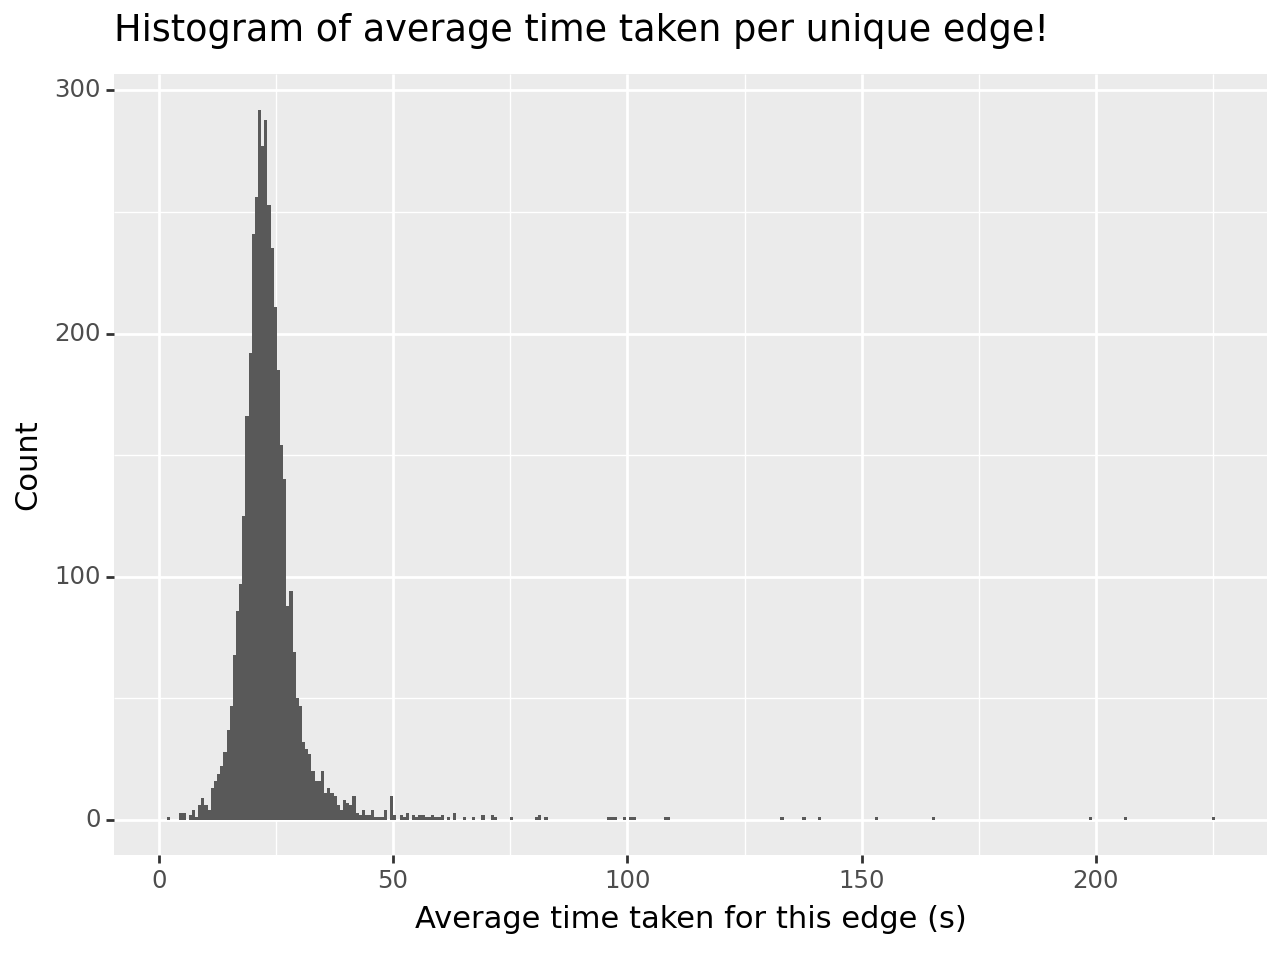

<Figure Size: (640 x 480)>

In [8]:
paths_and_time_fin = paths_finished[['durationInSec', 'path']].copy()
paths_and_time_fin['path_length'] = paths_and_time_fin['path'].apply(lambda x: len(x.split(';')))

display(paths_and_time_fin)

times_per_edge = defaultdict(list)

for idx, row in paths_and_time_fin.iterrows():
	elems_path = row['path'].split(';')
	for elem in elems_path:
		times_per_edge[elem].append(row['durationInSec'] / row['path_length'])

times_per_edge_micro = {key:np.mean(value) for key, value in times_per_edge.items()}

ggplot() + geom_histogram(aes(x = list(times_per_edge_micro.values()))) \
	+ labs(x='Average time taken for this edge (s)', y='Count', title='Histogram of average time taken per unique edge!')

Definitely promising!